# Team Convoluted Fishnets

Boshen Cui (20613736

Eddie Wang (20631370)

Charlie Wu (20550993)

### Project 8 - Multi-source domain adaptation for classification

# 1. Abstract 

This notebook presents an overview of our simple yet effective implementation for the multi-domain classification problem. We first train separate, specialized CNN classifiers for each domain that predicts accurately which class a respective domain image belongs to. Then we train a Domain CNN classier that classifies which domain an image belongs to. Finally we a weighted average combining all the predictions from the separate, specialized CNNs and the Domain CNN to label a new image. This method is shown to improve upon a baseline naive CNN multi-domain classification by 9%. Suggestions for further improvement for the model will also be mentioned.

## 1.1 Contributions

Boshen Cui - responsible for writing the code and some of the report.

Charlie Wu - responsible for writing the code and some of the report.

Eddie Wang - responsible for cleaning the notebook and writing some of the report.

# 2. Introduction

In this report we refer to the training domains as Sketch, Real, Painting, Quickdraw, and Infograph (SRPQI) and the unseen testing domain as Clipart.


## 2.1 Problem Statement
Multi-source domain adaptation deals with the problem of *Dataset Shift*. Data shift is a well known problem in machine learning in which the joint distribution of inputs and outputs differs between the training and the testing datasets. Within computer vision, this is a problem for classification models because prediction accuracy drops significantly when the model encounters an image from a domain that it has never seen before. In the VisDa dataset challenge, we are given the task of predicting which class a Clipart image belongs to but the given training data are only for images in the domains of Sketch, Painting, Real photographs, Quickdraw, and Infograph. 



## 2.2 Existing Work
Existing models that work well use the technique of fusing multiple CNNs. Firstly, a network is built that performs pixel-level adaptation between a source domain and target domain. The results are then used as an input to another model that runs the input through multiple networks specialized in different domains and combined at the end with a few fully connected layers. While there are many more approaches to address the dataset shift problem, they are mainly categorized into three types: 

1. sophisticated pre-processing of dataset such as data augmentation that convert data into one domain
2. training multiple networks with different architectures on multiple domains and adding some extra layer to combine the result
3. post-processing of data such as matching the distribution of the resulting set of decisions made by various networks specialized in particular domain. 

Some models even combine these three aspects.


## 2.3 Motivations to our Approach
Our approach is simpler and effective. Due to high computational limitations, we found that using multiple network architectures for each domain and integrating everything in couple last layers was too complicated. However, using multiple networks each specialize in each image domain seems to intuitively be in the right direction. Thus we use a same network architecture to train on different domains. Furthermore, the results of these networks specialized in one particular domain can be combined in a simpler way - using a weighted average which is decided by the similarity of the given image domain and the similarity of the targeted image domain. Thus, we use one more CNN that decides how similar a given image domain is from the target image domain. 


## 2.4 Technicalities to our Approach
Due to computational limitations, we used a subset of the dataset defined by using training and testing images on 10 classes across all the different domains. We train 5 different CNNs (corresponding to the SRPQI domains) using a pretrained ResNet34 architecture to predict which class an image belongs to in their respective domains. We then train a pretrained ResNet34 CNN as a Domain classifier (using only the SRPQI images) which decides which domain a given image is close to. The Clipart domain is completely unseen during the training phase. Lastly, the class of a Clipart image is predicted using a weighted average of the specialized CNNs and the Domain CNN classifiers.



## 2.5 Outline of the Notebook
First we will implement a naive ResNet34 classifier that is trained on all the training domain (SRPQI) images (restricted to 10 classes) and tested on unseen Clipart images, which serves as a baseline model to compare our results with.
Next we train the 5 specialized ResNet34 CNNs on each domain. To prevent the notebook from becoming too messy, we will only show the process and metrics of training a single specialized CNN. Training for the rest of the CNNs can be found in a separate notebook (domain_training.ipynb) but we have pretrained them and will simply load the rest of the models. Next we train the Domain CNN classifier. Finally we show the steps for predicting on unseen Clipart images. We will then summarize our conclusions and mention strengths/weaknesses and next steps. 

### Downloading Datasets

This will take a very long time depending on your internet speed. On Google Colab it's around 20-30 mins.

In [0]:
import os

if not os.path.exists("clipart"):
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/clipart.zip
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/clipart_train.txt
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/clipart_test.txt
    !unzip clipart.zip > /dev/null

if not os.path.exists("infograph"):
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/infograph.zip
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/infograph_train.txt
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/infograph_test.txt
    !unzip infograph.zip > /dev/null
    
if not os.path.exists("painting"):
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/painting.zip
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/painting_train.txt
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/painting_test.txt
    !unzip painting.zip > /dev/null

if not os.path.exists("quickdraw"):
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/quickdraw.zip
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/quickdraw_train.txt
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/quickdraw_test.txt
    !unzip quickdraw.zip > /dev/null

if not os.path.exists("real"):
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/real.zip
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/real_train.txt
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/real_test.txt
    !unzip real.zip > /dev/null

if not os.path.exists("sketch"):
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/sketch.zip
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/sketch_train.txt
    !wget http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/sketch_test.txt
    !unzip sketch.zip > /dev/null

--2019-12-17 04:00:24--  http://csr.bu.edu/ftp/visda/2019/multi-source/groundtruth/clipart.zip
Resolving csr.bu.edu (csr.bu.edu)... 128.197.10.202
Connecting to csr.bu.edu (csr.bu.edu)|128.197.10.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1270909081 (1.2G) [application/zip]
Saving to: ‘clipart.zip’

clipart.zip         100%[===================>]   1.18G  35.1MB/s    in 35s     

2019-12-17 04:01:00 (34.3 MB/s) - ‘clipart.zip’ saved [1270909081/1270909081]

--2019-12-17 04:01:00--  http://csr.bu.edu/ftp/visda/2019/multi-source/domainnet/txt/clipart_train.txt
Resolving csr.bu.edu (csr.bu.edu)... 128.197.10.202
Connecting to csr.bu.edu (csr.bu.edu)|128.197.10.202|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443819 (1.4M) [text/plain]
Saving to: ‘clipart_train.txt’

clipart_train.txt   100%[===================>]   1.38M   777KB/s    in 1.8s    

2019-12-17 04:01:02 (777 KB/s) - ‘clipart_train.txt’ saved [1443819/1443819]

--201

### Imports and Global Variables

In [0]:
# Python Library
import random
import math
import numbers
import platform
import copy

# Image Library
import numpy as np
import PIL
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import Pytorch
# Please see https://pytorch.org/get-started/locally/ for installation detail
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as tF
from torch.utils.data import Dataset
import torch.optim as optim
import time


In [0]:
USE_GPU = True
NUM_CLASSES = 10
NUM_DOMAINS = 5
NUM_WORKERS = 4
BATCH_SIZE = 1

#norm = ([0.485, 0.456, 0.406], 
#        [0.229, 0.224, 0.225]) this norm is used for using the ResNet34

transform = transforms.Compose(
    [transforms.Resize(224),
    transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
     ])

# 3. Naive Implementation

First, we train a big CNN using all the images from all the SRPQI domains and test its performance on the Clipart domain.

## 3.1 Loading the dataset

In [0]:
class MultiFileDataset(Dataset):
    def __init__(self, files, transform):
        self.samples = []
        self.size = 0
        self.transform = transform

        for file in files:
            with open(file, "r") as f:
                for line in f:
                    img_path, val = line.split(" ")
                    val = int(val)

                    if val >= NUM_CLASSES:
                        break
                
                    self.samples.append((self.transform(Image.open(img_path)), val))
                    self.size += 1
    
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        img, val = self.samples[idx]
        return img, val

In [0]:
domain_train_files = [
"infograph_train.txt",
"painting_train.txt",
"quickdraw_train.txt",
"real_train.txt",
"sketch_train.txt"
]

domain_test_files = [      
"infograph_test.txt",
"painting_test.txt",
"quickdraw_test.txt",
"real_test.txt",
"sketch_test.txt",
]

train_ds = MultiFileDataset(domain_train_files, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
test_ds = MultiFileDataset(domain_test_files, transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)

print(len(train_ds))
print(len(test_ds))

9357
4040


## 3.2 Defining the model

The CNN architecture is based on a pretrained ResNet34 and it will be the common architecture for all our CNNs.

In [0]:
# Define the network
import torchvision.models as models

# The Netwrok perform the classsificatino to given number of classes using Resnet34 
# This network can be initialize by calling it and passing the desired number classes in. For example, N = ClassificationNet(10) gives network of 10 classes
class ClassificationNet(nn.Module):
    def __init__(self, num_classes, criterion=None):
        super(ClassificationNet, self).__init__()

        resnet = models.resnet34(pretrained=True)
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.fc = nn.Linear(in_features=(512*1*1),out_features=(num_classes))
        
        self.criterion = criterion
    
    def forward(self,inp, gts=None):
        
        inp = self.conv1(inp)
        inp = self.bn1(inp)
        minp = self.maxpool(F.relu(inp))
        inp1 = self.layer1(minp)
        inp2 = self.layer2(inp1+minp)
        inp3 = self.layer3(inp2+(self.layer2[0].downsample(inp1)))
        inp4 = self.layer4(inp3+self.layer3[0].downsample(inp2))
        inp = self.avgpool(inp4)
        inp = inp.view(inp.size()[2]*inp.size()[3], -1)
        lfinal = self.fc(inp)

        return lfinal

In [0]:
criterion = nn.CrossEntropyLoss()
net = ClassificationNet(NUM_CLASSES, criterion=criterion)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 3.3 Training BigCNN model

Helper functions

In [0]:
def test(test_loader, net, classifying_domain=False):
    correct = 0
    total = 0
    test_loss = 0
    for i, data in enumerate(test_loader):
        if classifying_domain:
            inputs, labels, _ = data
        else:
            inputs, labels = data

        if USE_GPU:
            # convert to GPU compatible form
            inputs = inputs.cuda()
            net = net.cuda()
            labels = labels.cuda()
          
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs,labels)
        test_loss += loss.item()

    test_accuracy = 100 * correct / total
    return test_loss, test_accuracy

def train(train_loader, net, optimizer, classifying_domain):
    total = len(train_loader)
    total_loss = 0.0
    total_correct = 0.0

    for i, data in enumerate(train_loader):
        if classifying_domain:
            inputs, targets, _ = data
        else:
            inputs, targets = data

        if USE_GPU:
            inputs = inputs.cuda()
            net = net.cuda()
            targets = targets.cuda()
        
        optimizer.zero_grad()
        outputs = net.forward(inputs)
        loss = criterion(outputs,targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == targets).float().sum()
        total_correct += correct

    total_accuracy = (total_correct / total) * 100
    return total_loss, total_accuracy

Training loop (this takes around 1 hour using Google Colab GPUs)

In [0]:
def training_loop(train_loader, test_loader, net, epochs, name, classifying_domain=False):
    training_loss = []
    testing_loss = []
    training_acc = []
    testing_acc = []
    best_test_acc = 0

    for i in range(epochs):
        net.train()
        train_loss, train_accuracy = train(train_loader, net, optimizer, classifying_domain)
        net.eval()
        test_loss, test_accuracy = test(test_loader, net, classifying_domain)
        training_loss.append(train_loss)
        testing_loss.append(test_loss)
        training_acc.append(train_accuracy)
        testing_acc.append(test_accuracy)

        print("Epoch {}: TrainLoss={}, TrainAcc={}, TestLoss={}, TestAcc={}".format(i, train_loss, train_accuracy, test_loss, test_accuracy))
        # save model with best test accuracy
        if test_accuracy > best_test_acc:
            print('Saving ', name + "_BEST", ' with best test accuracy {}'.format(test_accuracy))
            print()
            torch.save(net.state_dict(), name + "_BEST")
            best_test_acc = test_accuracy
    
    torch.save(net.state_dict(), name + "_FINAL")
    return training_loss, training_acc, testing_loss, testing_acc

In [0]:
epochs = 10
training_loss, training_acc, testing_loss, testing_acc = training_loop(train_loader, test_loader, net, epochs, "BigCNN")

Epoch 0: TrainLoss=8480.27359700203, TrainAcc=70.17206573486328, TestLoss=6300.389349102974, TestAcc=65.51980198019803
Saving  BigCNN_1576556890  with best test accuracy 65.51980198019803

Epoch 1: TrainLoss=5697.9435448646545, TrainAcc=80.6882553100586, TestLoss=7651.195850610733, TestAcc=59.9009900990099
Epoch 2: TrainLoss=4057.7410777807236, TrainAcc=85.7646713256836, TestLoss=9700.119158267975, TestAcc=60.37128712871287
Epoch 3: TrainLoss=2872.7931209802628, TrainAcc=90.17847442626953, TestLoss=13911.091617822647, TestAcc=56.43564356435643
Epoch 4: TrainLoss=2200.0318155288696, TrainAcc=92.51897430419922, TestLoss=9389.334311842918, TestAcc=58.86138613861386
Epoch 5: TrainLoss=1555.1698520183563, TrainAcc=94.65641021728516, TestLoss=14948.838566064835, TestAcc=64.38118811881188
Epoch 6: TrainLoss=1135.43221950531, TrainAcc=96.13124084472656, TestLoss=20579.70744228363, TestAcc=61.95544554455446
Epoch 7: TrainLoss=753.0332016944885, TrainAcc=97.54195404052734, TestLoss=11752.9661768

## 3.4 Training Metrics for BigCNN

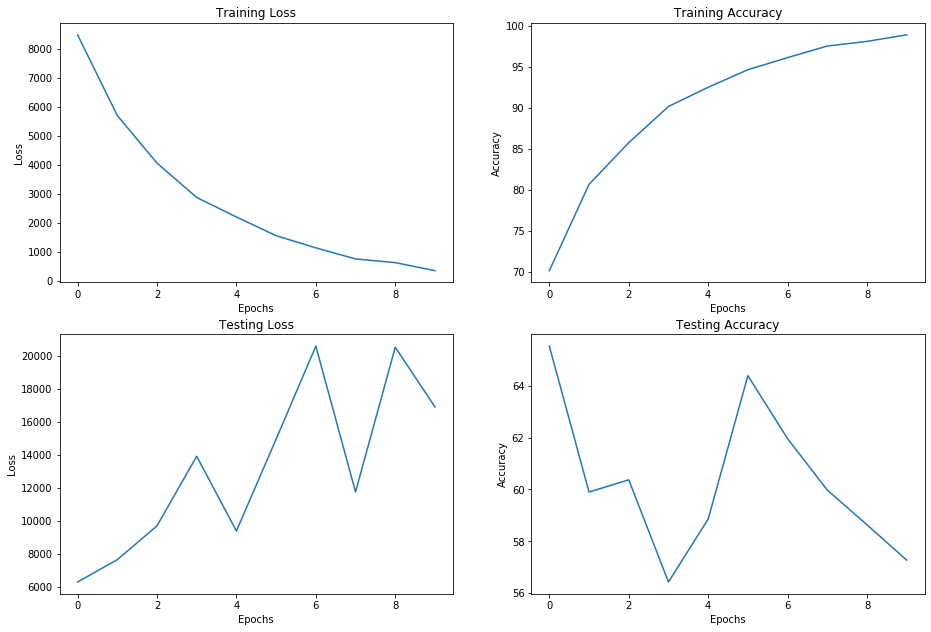

In [0]:
def plot_training_metrics(training_loss, training_acc, testing_loss, testing_acc):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.set_size_inches(15.5, 10.5)
    ax1.plot(training_loss)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')

    ax2.plot(training_acc)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training Accuracy')

    ax3.plot(testing_loss)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Testing Loss')

    ax4.plot(testing_acc)
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')
    ax4.set_title('Testing Accuracy')

    fig.canvas.draw()

plot_training_metrics(training_loss, training_acc, testing_loss, testing_acc)

It seems like the BigCNN is overfitting, as training accuracy is high but testing accuracy is still low (for images in SRPQI). Thus, training for even more epochs would likely not improve upon the generalization performance. Furthermore, it seems like the testing loss and accuracies are erratic even though the training loss and accuracies are behaving properly. Now let's see how the naive model performs on the unseen Clipart data.

## 3.5 Clipart Performance

We will use the same `test` helper function described in 3.3.



In [0]:
clipart_test_ds = MultiFileDataset(["clipart_train.txt", "clipart_test.txt"], transform=transform)
clipart_test_loader = torch.utils.data.DataLoader(clipart_test_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
print(len(clipart_test_loader))

1013


In [0]:
net.load_state_dict(torch.load('BigCNN_FINAL'))
net.eval()
_, test_accuracy = test(clipart_test_loader, net)
print('Test accuracy on clipart (most recently trained model): ', test_accuracy)

net.load_state_dict(torch.load('BigCNN_BEST'))
net.eval()
_, test_accuracy = test(clipart_test_loader, net)
print('Test accuracy on clipart (best model on validation set): ', test_accuracy)

Test accuracy on clipart (most recently trained model):  57.74925962487661
Test accuracy on clipart (best model on validation set):  58.83514313919052


The accuracy for the "best on SRPQI test set" and "most recently trained" naive models on the Clipart dataset is around 58%. Let's see if we can improve it with our method.

# 4. Training Separate, Specialized Domain CNNs

We now train 5 separate CNNs trained on their respective SRPQI domains. To prevent repetition in the notebook, we will provide one example of how to train one of these networks. The rest we will load from weights that were trained previously in the "separate_domain.ipynb" notebook. 

## 4.1 Loading the dataset


In [0]:
class VisDataset(Dataset):
    def __init__(self, file_name, transform, cap=None):
        self.samples = []
        self.size = 0
        self.transform = transform
        self.cap = cap

        with open(file_name, "r") as f:
            for line in f:
                img_path, val = line.split(" ")
                val = int(val)

                if val >= NUM_CLASSES:
                    break
            
                self.samples.append((self.transform(Image.open(img_path)), val))
                self.size += 1
                
                if cap and self.size == cap:
                  break
    
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        img, val = self.samples[idx]

        return img, val

In [0]:
DOMAIN = 'sketch'
train_ds = VisDataset(DOMAIN + "_train.txt", transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
test_ds = VisDataset(DOMAIN + "_test.txt", transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)

print(len(train_ds))
print(len(test_ds))

1220
530


For training and testing, we will conveniently use the same methods defined in 3.3 and 3.4.

## 4.2 Training the Specialized Model

In [0]:
criterion = nn.CrossEntropyLoss()
# note that we have to initialize our network first in order to use net.parameters()
net = ClassificationNet(NUM_CLASSES, criterion=criterion)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [0]:
epochs = 15
training_loss, training_acc, testing_loss, testing_acc = training_loop(train_loader, test_loader, net, epochs, DOMAIN)

Epoch 0: TrainLoss=1711.3075823783875, TrainAcc=52.704917907714844, TestLoss=928.5639995336533, TestAcc=47.54716981132076
Saving  sketch_BEST  with best test accuracy 47.54716981132076

Epoch 1: TrainLoss=1266.0058575868607, TrainAcc=66.0655746459961, TestLoss=956.2696712017059, TestAcc=45.471698113207545
Epoch 2: TrainLoss=922.8928052186966, TrainAcc=75.81967163085938, TestLoss=1071.6242364645004, TestAcc=52.83018867924528
Saving  sketch_BEST  with best test accuracy 52.83018867924528

Epoch 3: TrainLoss=747.2901307344437, TrainAcc=79.09835815429688, TestLoss=1215.8326176404953, TestAcc=50.37735849056604
Epoch 4: TrainLoss=536.2674273252487, TrainAcc=85.6557388305664, TestLoss=852.9981373548508, TestAcc=62.64150943396226
Saving  sketch_BEST  with best test accuracy 62.64150943396226

Epoch 5: TrainLoss=403.8942041397095, TrainAcc=89.26229858398438, TestLoss=6056.367991447449, TestAcc=38.490566037735846
Epoch 6: TrainLoss=286.8844553232193, TrainAcc=93.03279113769531, TestLoss=773.7827

## 4.3 Training Metrics for the Specialized Model

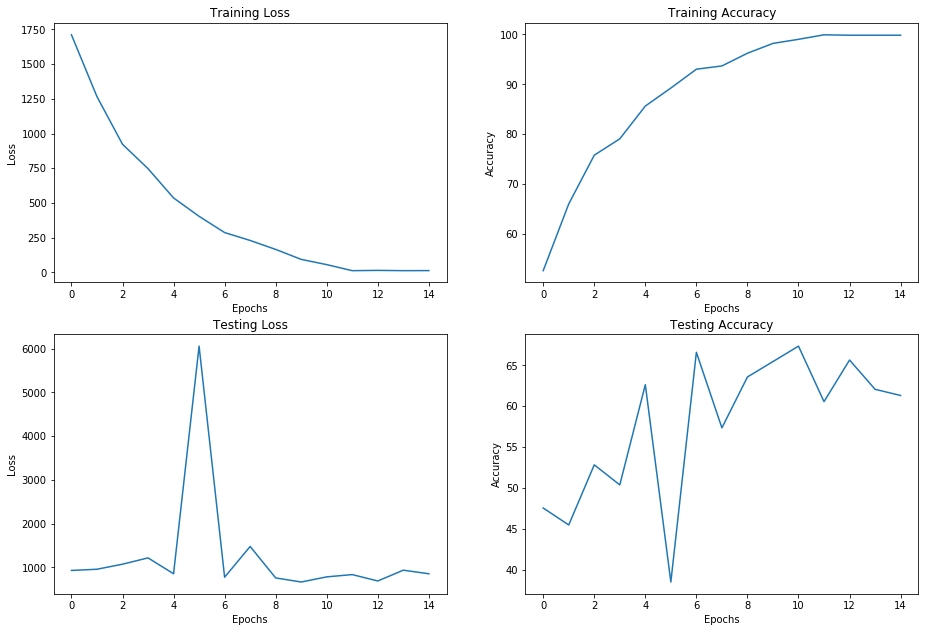

In [0]:
plot_training_metrics(training_loss, training_acc, testing_loss, testing_acc)

## 4.4 Loading the Rest of the Specialized Models

To avoid repetition, we will load the rest of the models which were pretrained already. Note that we will only use the last trained models.

In [0]:
# downloading the pretrained models
#!wget 'https://drive.google.com/uc?export=download&id=1r7KdoQ5UxAFNApYAViYyxG2AoBCzn3LW' -O sketch_FINAL
!wget 'https://drive.google.com/uc?export=download&id=1DBbRZCXIM19wsf0UgOhDEZuJlEB2BQc4' -O real_FINAL
!wget 'https://drive.google.com/uc?export=download&id=1NloCMck7WRskCJSIgKIllcpmUhExnCFc' -O quickdraw_FINAL
!wget 'https://drive.google.com/uc?export=download&id=1QBCbr01kgRK0u_F3Jl26g-5YAeyv8klL' -O painting_FINAL
!wget 'https://drive.google.com/uc?export=download&id=1c2bpChGCvi_n2paaiuowR_8W-KIb7sq5' -O infograph_FINAL

--2019-12-17 07:46:16--  https://drive.google.com/uc?export=download&id=1r7KdoQ5UxAFNApYAViYyxG2AoBCzn3LW
Resolving drive.google.com (drive.google.com)... 74.125.195.100, 74.125.195.102, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-7c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vfqnehdbp4cebrnpsjcmqb4n3pckosfk/1576562400000/02600567693616807958/*/1r7KdoQ5UxAFNApYAViYyxG2AoBCzn3LW?e=download [following]
--2019-12-17 07:46:23--  https://doc-0c-7c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vfqnehdbp4cebrnpsjcmqb4n3pckosfk/1576562400000/02600567693616807958/*/1r7KdoQ5UxAFNApYAViYyxG2AoBCzn3LW?e=download
Resolving doc-0c-7c-docs.googleusercontent.com (doc-0c-7c-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-0c-7c-docs.googleusercontent.com (doc-0c-

In [0]:
real = ClassificationNet(NUM_CLASSES)
real.load_state_dict(torch.load("real_FINAL"))
real.eval()
_, acc = test(clipart_test_loader, real)
print('real_FINAL accuracy on clipart: ', acc)

painting = ClassificationNet(NUM_CLASSES)
painting.load_state_dict(torch.load("painting_FINAL"))
painting.eval()
_, acc = test(clipart_test_loader, painting)
print('painting_FINAL accuracy on clipart: ', acc)

quickdraw = ClassificationNet(NUM_CLASSES)
quickdraw.load_state_dict(torch.load("quickdraw_FINAL"))
quickdraw.eval()
_, acc = test(clipart_test_loader, quickdraw)
print('quickdraw_FINAL accuracy on clipart: ', acc)

sketch = ClassificationNet(NUM_CLASSES)
sketch.load_state_dict(torch.load("sketch_FINAL"))
sketch.eval()
_, acc = test(clipart_test_loader, sketch)
print('sketch_FINAL accuracy on clipart: ', acc)

infograph = ClassificationNet(NUM_CLASSES)
infograph.load_state_dict(torch.load("infograph_FINAL"))
infograph.eval()
_, acc = test(clipart_test_loader, infograph)
print('infograph_FINAL accuracy on clipart: ', acc)

real_FINAL accuracy on clipart:  51.92497532082922
painting_FINAL accuracy on clipart:  58.144126357354395
quickdraw_FINAL accuracy on clipart:  15.498519249753208
sketch_FINAL accuracy on clipart:  48.37117472852912
infograph_FINAL accuracy on clipart:  34.05725567620928


Individually, the performance of these domains on the clipart domain are not good. Let's now create the Domain Classifer, which given an image will predict which domain the image belongs to. 

# 5. Training the Domain Classifier

Once again we will use the methods already defined in 3.3 and 3.4.

## 5.1 Loading the dataset 

In [0]:
class DomainDataset(Dataset):
    def __init__(self, files, transform):
        self.samples = []
        self.size = 0
        self.transform = transform

        for domain, file in enumerate(files):
            with open(file, "r") as f:
                for line in f:
                    img_path, cls = line.split(" ")
                    cls = int(cls)

                    if cls >= NUM_CLASSES:
                        break
                
                    self.samples.append((img_path, domain, cls))
                    self.size += 1
    
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        path, domain, cls = self.samples[idx]

        return self.transform(Image.open(path)), domain, cls

In [0]:
train_ds = DomainDataset(domain_train_files, transform=transform)
train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
test_ds = DomainDataset(domain_test_files, transform=transform)
test_loader = torch.utils.data.DataLoader(test_ds, shuffle=True, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)

print(len(train_ds))
print(len(test_ds))

9357
4040


## 5.2 Training and Evaluating Metrics of Domain Classifier

In [0]:
criterion = nn.CrossEntropyLoss()
# note that we have to initialize our network first in order to use net.parameters()
domain_classifier = ClassificationNet(NUM_DOMAINS, criterion=criterion)
optimizer = optim.SGD(domain_classifier.parameters(), lr=0.001, momentum=0.9)

This will take around 1.5 hour on Google Colab. Or you can skip the next two cells and run a pretrained Domain Classifier on the third cell.

In [0]:
epochs = 10
training_loss, training_acc, testing_loss, testing_acc = training_loop(train_loader, test_loader, domain_classifier, epochs, "Domain_Classifer", True)

Epoch 0: TrainLoss=6892.180782258511, TrainAcc=70.6316146850586, TestLoss=9661.002130031586, TestAcc=36.163366336633665
Saving  Domain_Classifer_BEST  with best test accuracy 36.163366336633665

Epoch 1: TrainLoss=3999.445958375931, TrainAcc=82.55850982666016, TestLoss=9400.51695382595, TestAcc=34.9009900990099
Epoch 2: TrainLoss=3133.933360815048, TrainAcc=87.03644561767578, TestLoss=14743.448656916618, TestAcc=38.73762376237624
Saving  Domain_Classifer_BEST  with best test accuracy 38.73762376237624

Epoch 3: TrainLoss=2447.728303551674, TrainAcc=90.03954315185547, TestLoss=13547.234679460526, TestAcc=40.51980198019802
Saving  Domain_Classifer_BEST  with best test accuracy 40.51980198019802

Epoch 4: TrainLoss=1972.6063869595528, TrainAcc=92.23041534423828, TestLoss=15079.666578531265, TestAcc=29.95049504950495
Epoch 5: TrainLoss=1498.2837201356888, TrainAcc=93.8762435913086, TestLoss=12361.454094409943, TestAcc=47.475247524752476
Saving  Domain_Classifer_BEST  with best test accurac

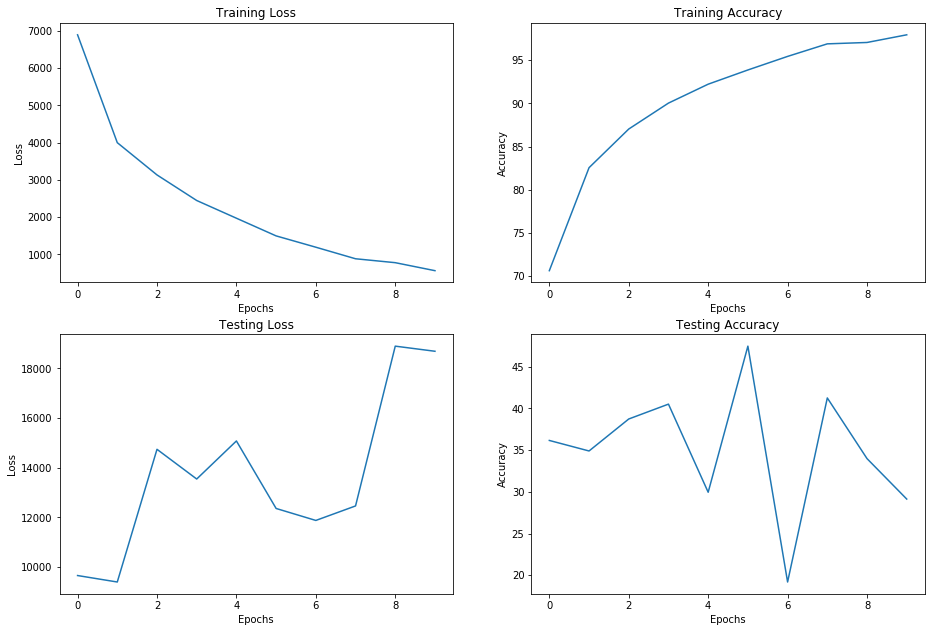

In [0]:
plot_training_metrics(training_loss, training_acc, testing_loss, testing_acc)

In [0]:
!wget 'https://drive.google.com/uc?export=download&id=1BZ4IqOznm387Jda-TfkvtkN8iM6NOjAB' -O Domain_Classifier_FINAL
domain_classifier = ClassificationNet(NUM_DOMAINS)
domain_classifier.load_state_dict(torch.load("Domain_Classifier_FINAL"))
domain_classifier.eval()

--2019-12-17 07:43:32--  https://drive.google.com/uc?export=download&id=1BZ4IqOznm387Jda-TfkvtkN8iM6NOjAB
Resolving drive.google.com (drive.google.com)... 74.125.195.100, 74.125.195.101, 74.125.195.113, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/if40atrkpcv3sej2jf9328t2ika4covg/1576562400000/16713605765144523283/*/1BZ4IqOznm387Jda-TfkvtkN8iM6NOjAB?e=download [following]
--2019-12-17 07:43:35--  https://doc-04-bs-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/if40atrkpcv3sej2jf9328t2ika4covg/1576562400000/16713605765144523283/*/1BZ4IqOznm387Jda-TfkvtkN8iM6NOjAB?e=download
Resolving doc-04-bs-docs.googleusercontent.com (doc-04-bs-docs.googleusercontent.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to doc-04-bs-docs.googleusercontent.com (doc-04-

## 5.3 Analyzing Domain Classifer

Now let's see which domains are most similar to clipart.

In [0]:
domain_classifier.eval()
domains = [0,0,0,0,0]
# the indices are in order of domain train file ingestion
# 0 - infograph
# 1 - painting
# 2 - quickdraw
# 3 - real
# 4 - sketch

for i, data in enumerate(clipart_test_loader):
    inputs, labels = data

    if USE_GPU:
        # convert to GPU compatible form
        inputs = inputs.cuda()
        net = domain_classifier.cuda()
        labels = labels.cuda()

    outputs = domain_classifier(inputs)
    _, predicted = torch.max(outputs.data, 1)
    domains[predicted] += 1

No handles with labels found to put in legend.


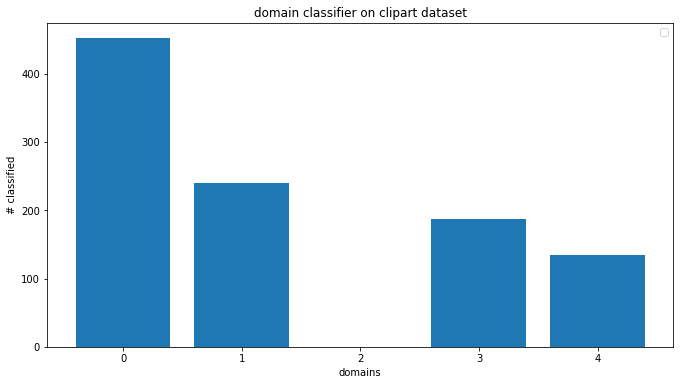

In [0]:
fig = plt.figure(figsize=(12,6))
plt.subplots_adjust(bottom=0.2,right=0.85,top=0.95)
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('domains')
ax.set_ylabel('# classified')
ax.set_title("domain classifier on clipart dataset")
ax.bar(x=[0,1,2,3,4], height=domains)
ax.legend(loc='upper right')
fig.canvas.draw()    

It seems like the Clipart domain is most similar to the Infograph domain although interestingly the Infograph specialized CNN defined in section 4 did not have the best classification accuracy on the Clipart test set (Painting did the best). However, Clipart seems to be least related to Quickdraw, which makes sense since the Quickdraw specialized CNN performed the worst on the Clipart test set at around 15.5% accuracy.

The intuition is that since Quickart is a bad classifier, combining the Domain Classifier with the Specialized Classifiers would put 0 weight on the Quickart specialized classier, since predictions from there would probably deter the model from predicting the true Clipart class its accuracy is quite bad. Furthermore, Clipart seems to be the most similar to the Infograph domain however the specialized Infograph model predictions were not the most accurate. Instead the specialized Painting CNN was the most accurate, but the Painting domain is the second-most similar domain to Clipart. Thus the combined model would "smooth out" predictions by using a weighted average technique and provide more robust classifications. Let's test this out!

# 6. Final Combined Multidomain Classifier

## 6.1 Defining the model

In [0]:
def normalize(vector):
    min_v = torch.min(vector)
    range_v = torch.max(vector) - min_v
    if range_v > 0:
        return (vector - min_v) / range_v
    else:
        return torch.zeros(vector.size())
    
class MD_Classifier(nn.Module):
    def __init__(self, num_classes, use_all=True, criterion=None):
        super(MD_Classifier, self).__init__()
        # self.conv1_1 = painting.conv1
        self.painting = painting
        self.quickdraw = quickdraw
        self.real = real
        self.sketch = sketch
        self.infograph = infograph
        self.domain_classifier = domain_classifier
        self.use_all = use_all

    def forward(self, inp, gts=None):
        pred1 = normalize(self.infograph(inp))
        pred2 = normalize(self.painting(inp))
        pred3 = normalize(self.quickdraw(inp))
        pred4 = normalize(self.real(inp))
        pred5 = normalize(self.sketch(inp))
        weights = normalize(self.domain_classifier(inp))

        if self.use_all:
            return pred1*weights[0][0] + pred2*weights[0][1] + pred3*weights[0][2] + pred4*weights[0][3] + pred5*weights[0][4]
        else:
            return pred2*weights[0][1] + pred4*weights[0][3] + pred5*weights[0][4]

## 6.2 Clipart Performance

In [0]:
md = MD_Classifier(NUM_CLASSES, use_all=True)
_, test_acc = test(clipart_test_loader, md)
print('Final model clipart accuracy: ', test_acc)
# md = MD_Classifier(NUM_CLASSES, use_all=False)
# test(clipart_test_loader, md)

Final model clipart accuracy:  67.12734452122409


The final combined model using a weighted average of the specialized CNNs (section 4) and Domain Classifier (section 5) had a accuracy of around 67%, which is about a 9% increase from the Naive BigCNN (section 3)!

# 7. Conclusions

## 7.1 Observations

Our method is a simplified but effective method of tackling the Multi-Source Domain Adaptation for Classification challenge. Since we had limited computing resources compared to the other methods in literature, we reduced the VisDa dataset to only predict on 10 classes and kept that subset consistent for all our experiments. Also, we only choose one backbone CNN model (ResNet34) compared to the other methods in the literature that experimented and bagged multiple backbone CNNs (for a single domain). Nonetheless our method of training separate, specialized CNNs based on the training domains (SRPQI) and combining them with a Domain Classifier CNN to predict using a weighted average outperformed a Naive CNN classifier by around 9% (67% accuracy vs. 58% accuracy).

## 7.2 Strengths/Weaknesses

The strength of our approach is that it by training specialized models and a general domain classifier and combining the two, we are able to make predictions that are smooth and averaged out with a balance of specialization and generalization. The result is that our model improves upon the baseline naive model by 9%. 

The weakness of our approach is that the final combined model has no way of "fine-tuning" or training it, it is sort of a "manual" weighted average method that combines different trained models. Thus there may be a way to make "smarter" decisions by incorporating another loss function for the final model and incorporating a learning algorithm with it. Also all the trained models suffered from some degree of overfitting. This may be due to the fact that the training data ratio in the 10 classes compared to testing data is relatively small. Thus the predictions in the final model may not be accurate since it is composed of overfit models originally.

## 7.3 Next steps

Although our approach shows promise by achieving a high accuracy against an unseen domain and beating out our benchmark, there is still a lot of work to be done to verify our results and see if it generalizes.

### 7.3.1 More Training

Due to our time and compute power limits, we only trained all of our models for 10-15 epochs maximum. Ideally, we would have liked to have trained some for longer, until we are sure they have reached an minima or hit some target test accuracy. Examples that come to mind are some of the underperforming domain Resnets (infographic, painting) and BigCNN. Our experiments should be repeated with all fully trained and tuned models to verify its performance.


### 7.3.2 Combatting Overfitting

All of trained models had an overfitting problem. One method to combat this is to perform more aggressive data augmentation such as random horizontal flips, slight rotations and translations, random resize crops, etc. Other methods include adding dropout and batch normalization. By adding these regularization techniques, we can then allow the models to train for longer epochs and hopefully produce more generalizable results.

### 7.3.3 Different Classes

For simplicity's sake, the 10 classes that we chose to work with were just the first 10 classes we saw in the train and test files. This lead to some imbalances - both in the number of samples/class, and samples/domain. For example, the training set for the infographic domain was only ~400 samples, or 40 samples/class, which may explain its poor accuracy.

Ideally, our experiments should be repeated with well chosen classes, with sample sizes that are balanced within each domain, and between domains.


### 7.3.4 More Classes

The full DomainNet dataset contains a whopping 345 classes, and over 500k images. Due to our limits, we only used a fraction of this. More time and work can be spent on repeating our experiments with more classes - retraining all models on 15 classes, 25, 50, or even the full 345, to see how well our results can generalize.

### 7.3.5 Different Unseen Domains

In this project, we used the Clipart domain as the "unseen" test domain against our models. More work can be done to verify our approach on different test domains - for example, leaving out Paint as the test domain and using Clipart, Real, Infographic, Sketch, Quickdraw as the training domains. Another idea worth testing is having multiple test domains - for example, leaving out Paint AND Clipart, and only using the remaining 4 to create a model.

Obviously, this would require retraining many different combos of the Domain Classifier, which will take a lot of time and power.